In [0]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random as rnd

import seaborn as sns
from matplotlib import style
style.use('seaborn-pastel')

from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

from tqdm import tqdm_notebook

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, 
    IAAPiecewiseAffine, IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, ElasticTransform
)

import random
import pickle

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
SEED = 42
np.random.seed(SEED)

# **Data Full (ale + family + google)**

---



In [0]:
loaded_data = np.load('/content/gdrive/My Drive/Colab Notebooks/AML/data.npz')
imgs = loaded_data['imgs']
labels = loaded_data['labels']

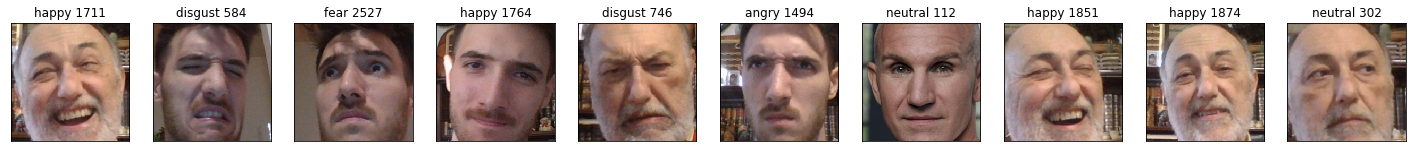

In [0]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(labels))
    plt.imshow(cv.cvtColor(imgs[l], cv.COLOR_BGR2RGB))
    plt.title(str(labels[l])+' '+str(l))

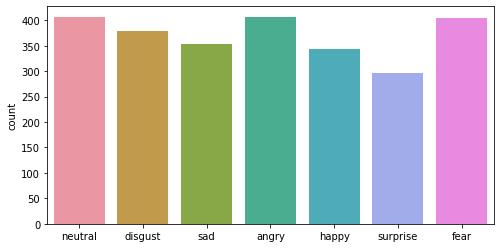

In [0]:
plt.figure(figsize = (8,4))
sns.countplot(labels)

#**VggFace**

---




In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-7_0gfo3n
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-7_0gfo3n
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=8797f43a221f284260d3ddebbd1b193028186b25a00adc4638c363b786ca8d13
  Stored in directory: /tmp/pip-ephem-wheel-cache-38cmovk_/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [0]:
X = np.array(imgs)
Y = np.array(labels)

X.shape, Y.shape

((2590, 224, 224, 3), (2590,))

In [0]:
le = LabelEncoder()
Y = le.fit_transform(Y)
# Y = to_categorical(Y, num_classes = 7)
X = X.astype('float64')
X = preprocess_input(X, version = 2)

np.max(X), np.min(X), X.shape, Y.shape

(163.5047, -131.0912, (2590, 224, 224, 3), (2590,))

In [0]:
def create_base_model(name_layer_stop):
  base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')

  for layer in base_model.layers:
    if layer.name == name_layer_stop:
      break
    else:
      layer.trainable = False
  
  return base_model

# base_model = create_base_model(name_layer_stop = 'conv5_1_1x1_reduce')
# base_model.summary()

In [0]:
def create_model(base_model):
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(512, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(256, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(128, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(7, activation = 'softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])
  return model

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
# config init
n_splits_kfolds = 5
n_epochs = 50
batch_size = 128

kfold = StratifiedKFold(n_splits = n_splits_kfolds, shuffle = True, random_state = SEED)
cvscores = []
count = 1

for train, test in kfold.split(X, Y):
  print('Start {}/{} folds'.format(count, n_splits_kfolds))
  #create data
  y_train = to_categorical(Y[train], num_classes = 7)
  x_train = X[train]
  x_test = X[test]
  y_test = Y[test]
  y_test = le.fit_transform(y_test)
  y_test = to_categorical(y_test, num_classes = 7)

  # create validation test
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = SEED, stratify = y_train) 
  # create base model (VGGFACE)
  base_model = create_base_model(name_layer_stop = 'conv5_1_1x1_reduce')
  # create model
  model = create_model(base_model)

  # callbacks list
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.001, restore_best_weights=True)
  filepath = "/content/gdrive/My Drive/Colab Notebooks/AML/weights-tmp.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
  #callbacks_list = [es, checkpoint]
  callbacks_list = [checkpoint]

  # fit model
  history_vggface = model.fit(x_train, y_train, epochs = n_epochs, validation_data = (x_val, y_val),
                              verbose = 1, batch_size = batch_size, callbacks = callbacks_list)
  
  # scores model
  model.load_weights("/content/gdrive/My Drive/Colab Notebooks/AML/weights-tmp.best.hdf5")
  score = model.evaluate(x_test, y_test, verbose=1)
  accuracy = 100*score[1]
  loss = score[0]
  print("Post-training accuracy: {} %".format(round(accuracy, 3)))
  print("Post-training loss: {}".format(round(loss, 4)))
  cvscores.append(accuracy)

  count += 1


Start 1/5 folds
Train on 1655 samples, validate on 414 samples
Epoch 1/50
1655/1655 [==============================] - 68s 41ms/step - loss: 2.9579 - acc: 0.1511 - val_loss: 2.2221 - val_acc: 0.0870
Epoch 2/50
1655/1655 [==============================] - 6s 4ms/step - loss: 2.1115 - acc: 0.1323 - val_loss: 1.9427 - val_acc: 0.2101
Epoch 3/50
1655/1655 [==============================] - 6s 4ms/step - loss: 2.0696 - acc: 0.1426 - val_loss: 1.9403 - val_acc: 0.1594
Epoch 4/50
1655/1655 [==============================] - 6s 4ms/step - loss: 2.0796 - acc: 0.1378 - val_loss: 1.9383 - val_acc: 0.1353
Epoch 5/50
1655/1655 [==============================] - 6s 4ms/step - loss: 2.0383 - acc: 0.1547 - val_loss: 1.9322 - val_acc: 0.1570
Epoch 6/50
1655/1655 [==============================] - 6s 4ms/step - loss: 2.0188 - acc: 0.1656 - val_loss: 1.9229 - val_acc: 0.1812
Epoch 7/50
1655/1655 [==============================] - 6s 4ms/step - loss: 1.9947 - acc: 0.1849 - val_loss: 1.8747 - val_acc: 0.13

In [0]:
print(cvscores)
print("mean accuracy: {} % (sd: +/- {} %)".format(np.mean(cvscores), np.std(cvscores)))

[86.37236089029147, 86.53846153846155, 85.13513511212176, 85.07751937984496, 88.34951457468051]
mean accuracy: 86.29459829908005 % (sd: +/- 1.1927978183580958 %)


In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, min_delta=0.01)
# checkpoint
filepath = "/content/gdrive/My Drive/Colab Notebooks/AML/weights-senet50-test.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]